

```
# This is formatted as code
```

Reference Links:<br>
VGG16: https://www.kaggle.com/code/razinw/asl-alphabet-classification-with-vgg16

Transfer Learnig comparisons: https://www.kaggle.com/code/databeru/recognition-of-asl-acc-99-66

Basic CNN 99% accuracy: https://www.kaggle.com/code/namanmanchanda/asl-detection-99-accuracy (Used for preprocessing)


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
from tensorflow import keras
import opendatasets as od
import os
import cv2
import skimage
from skimage.transform import resize
import seaborn as sn
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tghegde
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:07<00:00, 149MB/s]


In [ ]:
# {"username":"premabhinav","key":"6c7192c5606a7e6330e3ea5e41e41680"}

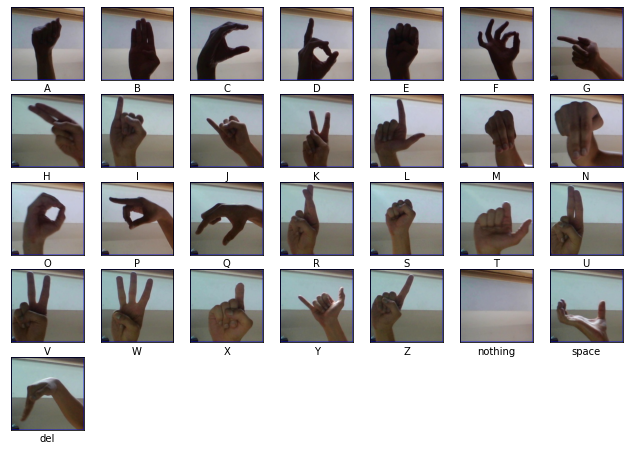

In [ ]:
#importing the data and visualizing each category
train_dir = './asl-alphabet/asl_alphabet_train/asl_alphabet_train/'

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

In [ ]:
# Loading the data and splitting train data int0 50-50 to reduce samples (Train and validation)
train_dir = './asl-alphabet/asl_alphabet_train/asl_alphabet_train/' 
def load_data(train_dir):
    images = []
    labels = []
    size = 75,75 # inceptionV3 requires minimum size of (75,75)
    index = -1
    for folder in os.listdir(train_dir):
        index +=1
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(index)
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    labels = to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.5, stratify=labels)
    
    print('Loaded', len(x_train),'images for training,','Train data shape =', x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =', x_test.shape)
    
    return x_train, x_test, y_train, y_test
X_train, X_test, y_train, y_test = load_data(train_dir)

Loaded 43500 images for training, Train data shape = (43500, 75, 75, 3)
Loaded 43500 images for testing Test data shape = (43500, 75, 75, 3)


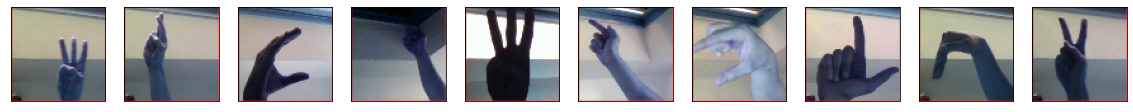

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_train[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.savefig('train_data.jpg');

In [ ]:
# This is done to save CPU and RAM space while working.
#del X_test # deleting as we are downsampling
#del y_test
gc.collect()
#del x_train
#del x_test

43405

In [ ]:
# Model Imports

from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Modelling the data

# 1) Using InceptionV3


model = Sequential()
model.add(InceptionV3(weights="imagenet", input_shape=(75,75,3), include_top=False))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(128, activation='relu'))
model.add(Dense(512))
model.add(Dense(128, activation='relu'))
model.add(Dense(29,activation="softmax"))

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                         

In [ ]:
classes = 29
batch = 128
epochs = 3
lr = 0.00001

opt = Adam(lr)
loss = CategoricalCrossentropy()

In [ ]:
model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

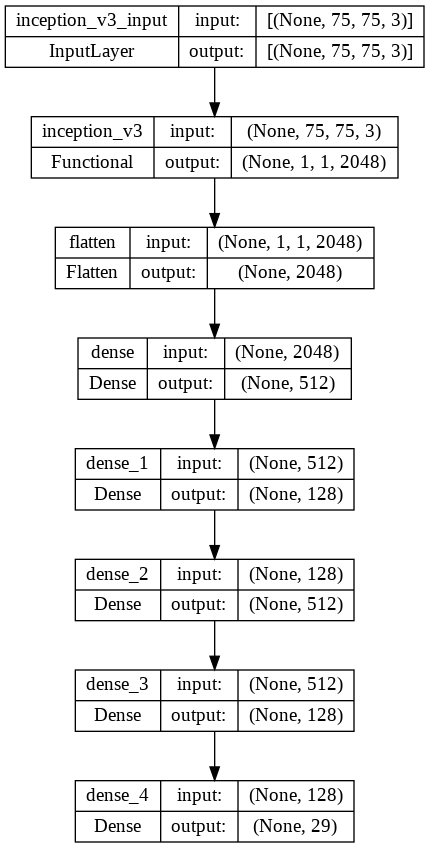

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [ ]:
history = model.fit(X_train,y_train,epochs = 10,shuffle = True,verbose = 1, validation_split = 0.1, callbacks = [earlystopping]) # not included early stopping due to error

Epoch 1/10
1224/1224 [==============================] - 79s 51ms/step - loss: 2.5837 - accuracy: 0.3087 - val_loss: 1.1331 - val_accuracy: 0.7244
Epoch 2/10
1224/1224 [==============================] - 59s 48ms/step - loss: 0.7211 - accuracy: 0.8045 - val_loss: 0.2711 - val_accuracy: 0.9329
Epoch 3/10
1224/1224 [==============================] - 59s 48ms/step - loss: 0.2801 - accuracy: 0.9211 - val_loss: 0.1408 - val_accuracy: 0.9703
Epoch 4/10
1224/1224 [==============================] - 60s 49ms/step - loss: 0.1520 - accuracy: 0.9558 - val_loss: 0.0382 - val_accuracy: 0.9890
Epoch 5/10
1224/1224 [==============================] - 62s 50ms/step - loss: 0.0932 - accuracy: 0.9731 - val_loss: 0.0381 - val_accuracy: 0.9913
Epoch 6/10
1224/1224 [==============================] - 61s 50ms/step - loss: 0.0610 - accuracy: 0.9826 - val_loss: 0.0715 - val_accuracy: 0.9837
Epoch 7/10
1224/1224 [==============================] - 60s 49ms/step - loss: 0.0460 - accuracy: 0.9865 - val_loss: 0.1397 -

In [ ]:
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,2.583650,0.308736,1.133088,0.724368
1,0.721090,0.804521,0.271136,0.932874
2,0.280134,0.921124,0.140805,0.970345
3,0.151980,0.955760,0.038199,0.988966
4,0.093229,0.973103,0.038072,0.991264
5,0.061008,0.982580,0.071480,0.983678
6,0.046032,0.986539,0.139699,0.983448
7,0.035906,0.989706,0.013835,0.995632
8,0.026214,0.992797,0.008964,0.995862
9,0.022363,0.993384,0.258003,0.985057


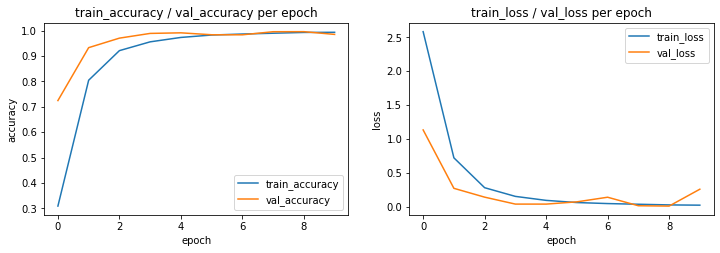

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('train_accuracy / val_accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('train_loss / val_loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_vs_acc.jpg')
plt.show()


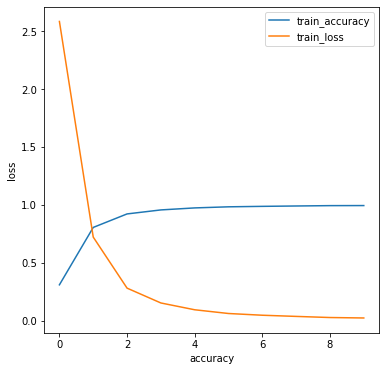

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_vs_acc.jpg')
plt.show()

In [ ]:
model.evaluate(X_test,y_test,verbose=1)

1360/1360 [==============================] - 23s 17ms/step - loss: 0.3032 - accuracy: 0.9829


[0.30317288637161255, 0.982942521572113]

In [ ]:
y_pred = model.predict(X_test)
print("Predictions done...")

1360/1360 [==============================] - 20s 14ms/step
Predictions done...


In [ ]:
y_classified = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
def plot_confusion_matrix(y_classified, y_true):
  # Compute confusion matrix
  c_mat = np.zeros((29,29))
  for i in range(len(y_true)):
    c_mat[y_classified[i], y_true[i] ] += 1

  accuracy = accuracy_score(y_classified, y_true) * 100
  group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])
  plt.figure(figsize=(25,25))
  sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
  plt.title("Confusion Matrix", fontsize=18)
  plt.ylabel('Output Class', fontsize=18)
  plt.xlabel('Target Class \n Accuracy: ' + '%.2f'%accuracy + "%", fontsize=18)
  plt.savefig('confusionMat.jpg')

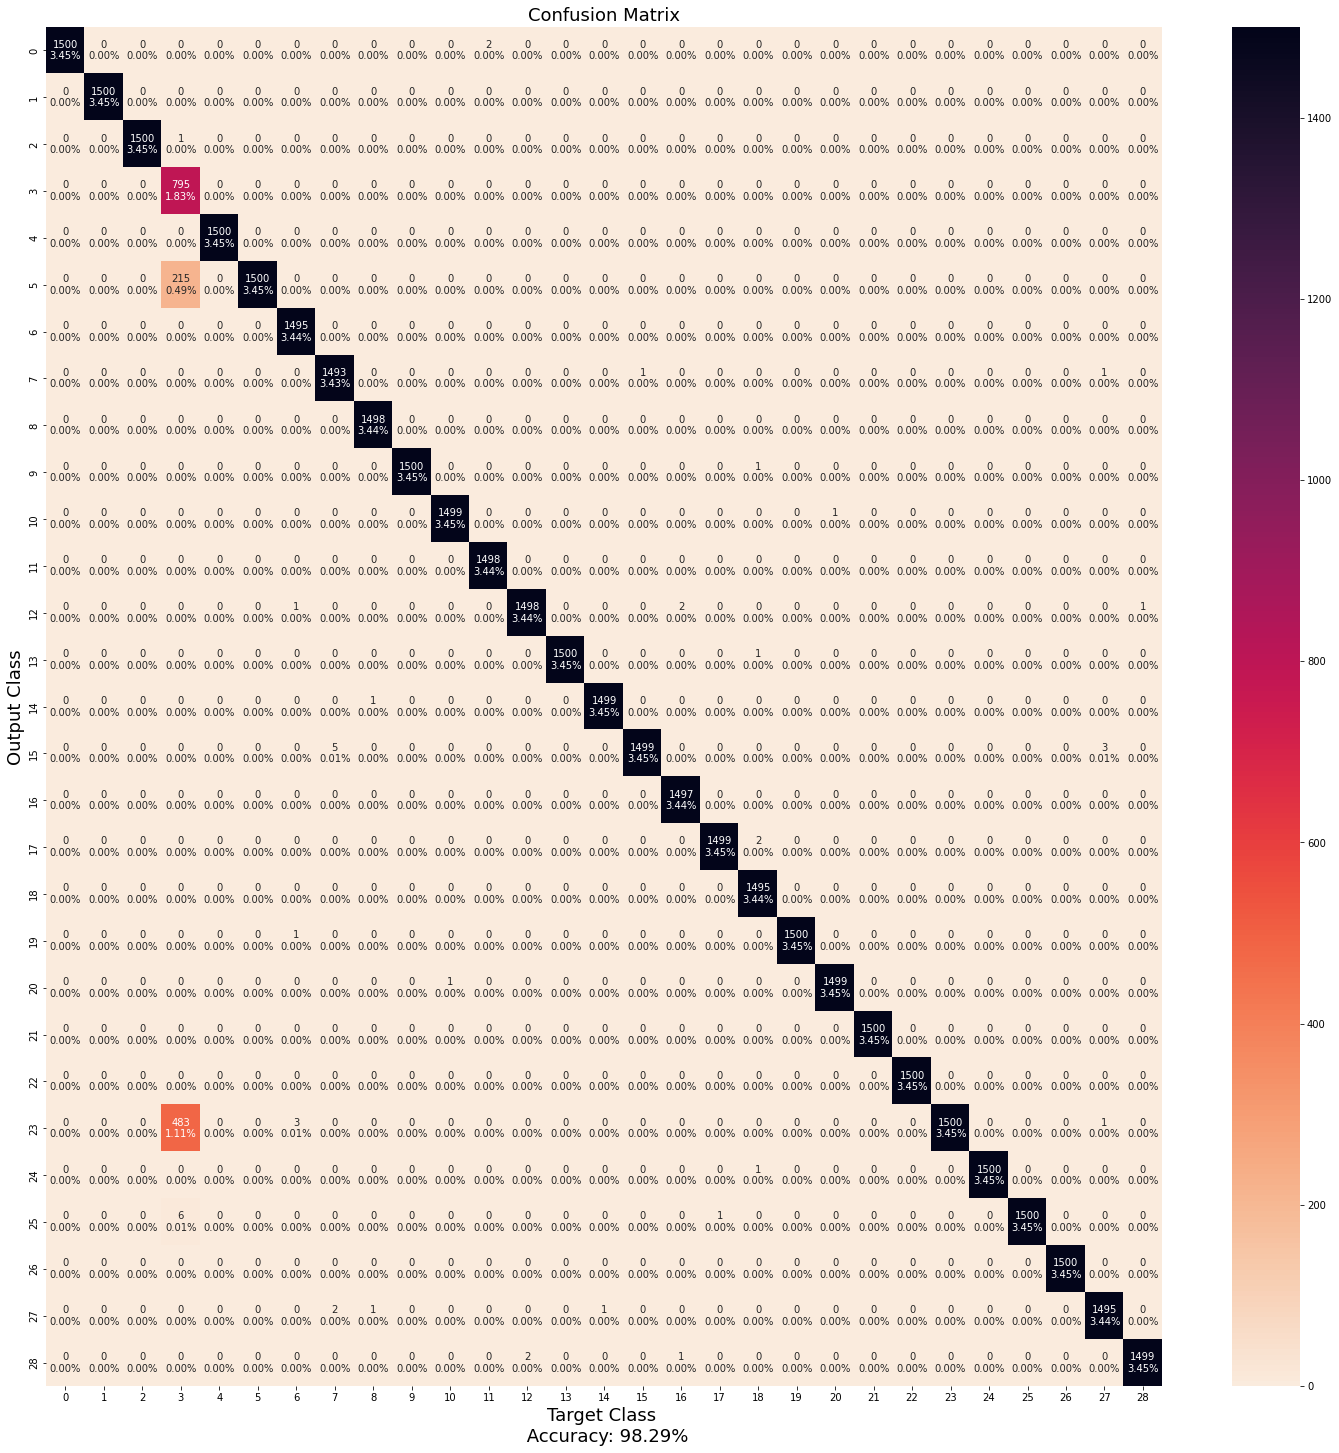

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_classified, y_true)

In [ ]:
gc.collect()

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

metric = tfa.metrics.F1Score(num_classes=29,average='weighted')
metric.update_state(y_test, y_pred)
result = metric.result()
print('F1 Score is :',result.numpy())